In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [5]:
csv_file = 'loans_risk_binary.csv'
data = pd.read_csv(csv_file, index_col=False)
y = data['loan_risk']
X = data.drop(columns=['loan_risk'], axis=1)


# Data preprocessing


In [6]:
Xtrain, Xtest_val, y_train, y_test_val = train_test_split(X,y, test_size = 0.3)
Xtest, Xval, y_test, y_val = train_test_split(Xtest_val,y_test_val, test_size = 0.5)

ordinal_features = Xtrain.columns[Xtrain.dtypes!='object']
categorical_features = Xtrain.columns[Xtrain.dtypes=='object']
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), 
                                      ('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

column_transformer = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                     ('cat', categorical_transformer, categorical_features)])
column_transformer.fit(Xtrain)
X_train = column_transformer.transform(Xtrain)
X_test = column_transformer.transform(Xtest)
X_val = column_transformer.transform(Xval)
y_train_en = (y_train=='Charged Off').astype(int).values
y_test_en = (y_test=='Charged Off').astype(int).values
y_val_en = (y_val=='Charged Off').astype(int).values

# PyMC3 Model training

In [7]:
import pymc3 as pm
import pymc3
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

import theano.tensor as T
import theano
floatX = theano.config.floatX

def construct_nn(ann_input, nn_labels):
    n_hidden = 4
    # Weight inizialization
    init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
    
        # Prior distribution for input weights
        weights_in_1 = pm.Normal('w_in_1', 0., sd=1.,
                                 shape=(X_train.shape[1], n_hidden),
                                 testval=init_1)

        # Activation hidden layer
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))

        # Prior distribution for output weights
        weights_1_out = pm.Normal('w_1_out', 0., sd=1.,
                                  shape=(n_hidden,),
                                  testval=init_out)


        # Output activation
        act_out = pm.math.sigmoid(pm.math.dot(act_1,
                                              weights_1_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=nn_labels,
                           total_size=y_train_en.shape[0] 
                          )
    return neural_network


nn_input = theano.shared(X_train)
nn_labels = theano.shared(y_train_en)
neural_network = construct_nn(nn_input, nn_labels)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/gillus/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/gillus/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
%%time

with neural_network:
    approx = pm.fit(n=25000, method=pm.ADVI())

Average Loss = 10,987: 100%|██████████| 25000/25000 [16:49<00:00, 24.77it/s] 
Finished [100%]: Average Loss = 10,987


CPU times: user 1h 21min 12s, sys: 1h 39min 3s, total: 3h 15s
Wall time: 16min 54s


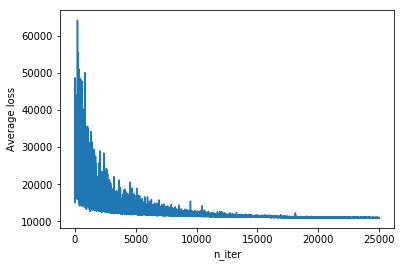

In [12]:
plt.plot(approx.hist)
plt.xlabel('n_iter')
plt.ylabel('Average loss')
plt.savefig('loss.png', dpi=600)

# Model scoring and metrics 

In [56]:
from sklearn.metrics import classification_report

# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')

# Do not forget test_values or set theano.config.compute_test_value = 'off'
#x.tag.test_value = np.empty_like(X_train[:10])
#n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p, size=n,
                                   more_replacements={nn_input:x})

sample_proba = theano.function([x, n], _sample_proba)


n_samples = 100 # Number of model samples for a prediction
pred = sample_proba(X_test, n_samples).mean(0) > 0.5
print(classification_report(y_test_en,pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4815
           1       0.90      0.11      0.19      1025

    accuracy                           0.84      5840
   macro avg       0.87      0.55      0.55      5840
weighted avg       0.85      0.84      0.79      5840



# Inspecting the model distributions

In [31]:
trace = approx.sample()

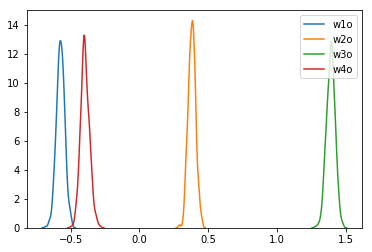

In [38]:
sns.kdeplot(trace['w_1_out'][:,0],label='w1o')
sns.kdeplot(trace['w_1_out'][:,1],label='w2o')
sns.kdeplot(trace['w_1_out'][:,2],label='w3o')
sns.kdeplot(trace['w_1_out'][:,3],label='w4o')
plt.savefig('w_pdf.png',dpi=600)

In [39]:
out = sample_proba(X_test[100:220,:], 1000)

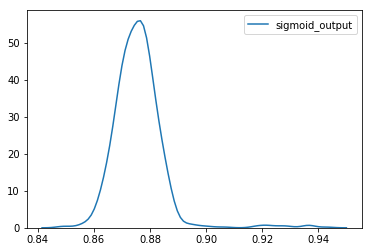

In [43]:
sns.kdeplot(out[:,out.mean(axis=0).argmax()],label='sigmoid_output')
plt.savefig('sigmoid_pdf.png',dpi=600)